# Import the Dataset

Notebook Link: https://colab.research.google.com/drive/1LStiKdz-STmpNVKyt3CEL8glKqBUS1uN?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

RAW_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset"
AUG_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset_augmented"

# print class folders
print(os.listdir(RAW_DATASET_DIR))

['trash', 'glass', 'cardboard', 'plastic', 'paper', 'metal']


# Installations

In [3]:
!pip install albumentations opencv-python tqdm

# Test Loading an image

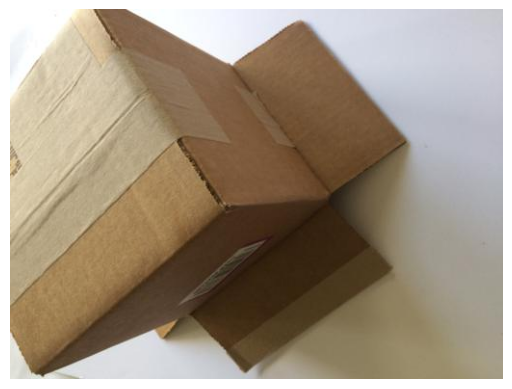

In [4]:
import cv2
import matplotlib.pyplot as plt

# Pick a sample image from a class folder
sample_image_path = os.path.join(RAW_DATASET_DIR, "cardboard", os.listdir(os.path.join(RAW_DATASET_DIR, "cardboard"))[0])
img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

# Configurations

In [6]:
from albumentations import (
    Compose, Rotate, HorizontalFlip, VerticalFlip, RandomBrightnessContrast,
    GaussNoise, RandomCrop, ShiftScaleRotate, Blur, Normalize
)

# ----------------------------
# (1) CONFIGURATION
# ----------------------------
TARGET_COUNT_PER_CLASS = 500
IMG_SIZE = 224
TRAIN_RATIO = 0.8

# Define per-class augmentations
CLASS_AUGMENTATIONS = {
    "cardboard": Compose([
        Rotate(limit=15, p=0.7),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.5),
        GaussNoise(p=0.3),
        RandomCrop(width=200, height=200, p=0.3),
        Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ]),
    "glass": Compose([
        Rotate(limit=15, p=0.5),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.5),
        Blur(blur_limit=3, p=0.3),
        GaussNoise(p=0.2),
        Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ]),
    "metal": Compose([
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.5),
        GaussNoise(p=0.3),
        RandomCrop(width=200, height=200, p=0.3),
        Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ]),
    "paper": Compose([
        Rotate(limit=10, p=0.5),
        HorizontalFlip(p=0.3),
        RandomBrightnessContrast(p=0.3),
        GaussNoise(p=0.1),
        Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ]),
    "plastic": Compose([
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.6),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.5),
        GaussNoise(p=0.2),
        RandomCrop(width=200, height=200, p=0.3),
        Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ]),
    "trash": Compose([
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25, p=0.9),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.3),
        RandomBrightnessContrast(p=0.7),
        GaussNoise(p=0.4),
        RandomCrop(width=200, height=200, p=0.5),
        Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ])
}

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Used Functions

In [7]:
import os
import cv2
import numpy as np

# ----------------------------
# (2) FUNCTIONS
# ----------------------------
def load_images_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append((img, filename))
    return images

def save_image(image, path):
    # Convert normalized image back to uint8 before saving
    img = ((image * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406]))
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Augmentation

In [14]:
import os
import random
import cv2
from tqdm import tqdm
import shutil

# ----------------------------
# (3) MAIN AUGMENTATION SCRIPT
# ----------------------------

if os.path.exists(AUG_DATASET_DIR):
    shutil.rmtree(AUG_DATASET_DIR)
os.makedirs(AUG_DATASET_DIR, exist_ok=True)

report = {}

for cls in os.listdir(RAW_DATASET_DIR):
    class_folder = os.path.join(RAW_DATASET_DIR, cls)
    images = load_images_from_folder(class_folder)
    current_count = len(images)
    needed = TARGET_COUNT_PER_CLASS - current_count

    print(f"\nProcessing class '{cls}' - current: {current_count}, target: {TARGET_COUNT_PER_CLASS}")
    cls_aug_dir = os.path.join(AUG_DATASET_DIR, cls)
    os.makedirs(cls_aug_dir, exist_ok=True)

    # Save original images first
    for img, fname in images:
        save_path = os.path.join(cls_aug_dir, fname)
        save_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), save_path)

    # Apply augmentation to reach target count
    pbar = tqdm(total=needed)
    while needed > 0:
      img, _ = random.choice(images)
      augmented = CLASS_AUGMENTATIONS[cls](image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      aug_img = augmented['image']
      save_path = os.path.join(cls_aug_dir, f"aug_{random.randint(0, int(1e9))}.jpg")
      save_image(aug_img, save_path)
      needed -= 1
      pbar.update(1)
    pbar.close()
    report[cls] = len(os.listdir(cls_aug_dir))


Processing class 'trash' - current: 106, target: 500


100%|██████████| 394/394 [00:09<00:00, 42.93it/s]



Processing class 'glass' - current: 385, target: 500


100%|██████████| 115/115 [00:02<00:00, 43.54it/s]



Processing class 'cardboard' - current: 247, target: 500


100%|██████████| 253/253 [00:05<00:00, 44.29it/s]



Processing class 'plastic' - current: 363, target: 500


100%|██████████| 137/137 [00:03<00:00, 45.28it/s]



Processing class 'paper' - current: 449, target: 500


100%|██████████| 51/51 [00:01<00:00, 44.19it/s]



Processing class 'metal' - current: 315, target: 500


100%|██████████| 185/185 [00:04<00:00, 44.95it/s]


# Report

In [15]:
import os

# Paths
AUG_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset_augmented"
RAW_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset"

def count_images_in_folder(folder):
    """Count images in a folder (jpg/png only)."""
    return len([f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png"))])

print("\n=== Raw Dataset Counts ===")
raw_classes = sorted([cls for cls in os.listdir(RAW_DATASET_DIR) if os.path.isdir(os.path.join(RAW_DATASET_DIR, cls))])
for cls in raw_classes:
    cls_folder = os.path.join(RAW_DATASET_DIR, cls)
    total_count = count_images_in_folder(cls_folder)
    print(f"{cls}: total={total_count} images")

print("\n=== Augmented Dataset Counts ===")
aug_classes = sorted([cls for cls in os.listdir(AUG_DATASET_DIR) if os.path.isdir(os.path.join(AUG_DATASET_DIR, cls))])
for cls in aug_classes:
    cls_folder = os.path.join(AUG_DATASET_DIR, cls)
    total_count = count_images_in_folder(cls_folder)
    print(f"{cls}: total={total_count} images")


=== Raw Dataset Counts ===
cardboard: total=259 images
glass: total=401 images
metal: total=328 images
paper: total=476 images
plastic: total=386 images
trash: total=110 images

=== Augmented Dataset Counts ===
cardboard: total=500 images
glass: total=500 images
metal: total=500 images
paper: total=500 images
plastic: total=500 images
trash: total=500 images


# Train Validation Split

In [16]:
import os
import random
import shutil

# Paths
AUG_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset_augmented"
SPLIT_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset_train_val"
TRAIN_DIR = os.path.join(SPLIT_DATASET_DIR, "train")
VAL_DIR = os.path.join(SPLIT_DATASET_DIR, "val")

# Create new directories
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

TRAIN_RATIO = 0.8  # 80% train, 20% validation

# Get class folders from augmented dataset
class_folders = [cls for cls in os.listdir(AUG_DATASET_DIR) if os.path.isdir(os.path.join(AUG_DATASET_DIR, cls))]

for cls in class_folders:
    cls_path = os.path.join(AUG_DATASET_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".png"))]
    random.shuffle(images)

    split_idx = int(len(images) * TRAIN_RATIO)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    cls_train_dir = os.path.join(TRAIN_DIR, cls)
    cls_val_dir = os.path.join(VAL_DIR, cls)
    os.makedirs(cls_train_dir, exist_ok=True)
    os.makedirs(cls_val_dir, exist_ok=True)

    # Copy images (I dont remove from original augmented dataset)
    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(cls_train_dir, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(cls_val_dir, img))

print("Train/Validation split created successfully in 'dataset_train_validation'.")

Train/Validation split created successfully in 'dataset_train_validation'.


# Final Report

In [17]:
import os

# Paths
RAW_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset"
AUG_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset_augmented"
SPLIT_DATASET_DIR = "/content/drive/MyDrive/College/MyLastYear/MachineLearning/dataset_train_val"
TRAIN_DIR = os.path.join(SPLIT_DATASET_DIR, "train")
VAL_DIR = os.path.join(SPLIT_DATASET_DIR, "val")

def count_images_in_folder(folder):
    """Count images in a folder (jpg/png only)."""
    return len([f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png"))])

# ----------------------------
# Raw dataset counts
# ----------------------------
print("\n=== Raw Dataset Counts ===")
raw_classes = sorted([cls for cls in os.listdir(RAW_DATASET_DIR) if os.path.isdir(os.path.join(RAW_DATASET_DIR, cls))])
for cls in raw_classes:
    cls_folder = os.path.join(RAW_DATASET_DIR, cls)
    total_count = count_images_in_folder(cls_folder)
    print(f"{cls}: total={total_count} images")

# ----------------------------
# Augmented dataset counts
# ----------------------------
print("\n=== Augmented Dataset Counts ===")
aug_classes = sorted([cls for cls in os.listdir(AUG_DATASET_DIR) if os.path.isdir(os.path.join(AUG_DATASET_DIR, cls))])
for cls in aug_classes:
    cls_folder = os.path.join(AUG_DATASET_DIR, cls)
    total_count = count_images_in_folder(cls_folder)
    print(f"{cls}: total={total_count} images")

# ----------------------------
# Train/Validation split counts
# ----------------------------
print("\n=== Train/Validation Split Counts ===")
split_classes = sorted([cls for cls in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, cls))])
for cls in split_classes:
    train_count = count_images_in_folder(os.path.join(TRAIN_DIR, cls))
    val_count = count_images_in_folder(os.path.join(VAL_DIR, cls))
    total_count = train_count + val_count
    print(f"{cls}: train={train_count}, val={val_count}, total={total_count}")


=== Raw Dataset Counts ===
cardboard: total=259 images
glass: total=401 images
metal: total=328 images
paper: total=476 images
plastic: total=386 images
trash: total=110 images

=== Augmented Dataset Counts ===
cardboard: total=500 images
glass: total=500 images
metal: total=500 images
paper: total=500 images
plastic: total=500 images
trash: total=500 images

=== Train/Validation Split Counts ===
cardboard: train=400, val=100, total=500
glass: train=400, val=100, total=500
metal: train=400, val=100, total=500
paper: train=400, val=100, total=500
plastic: train=400, val=100, total=500
trash: train=400, val=100, total=500
